In [ ]:
!pip install numba

r


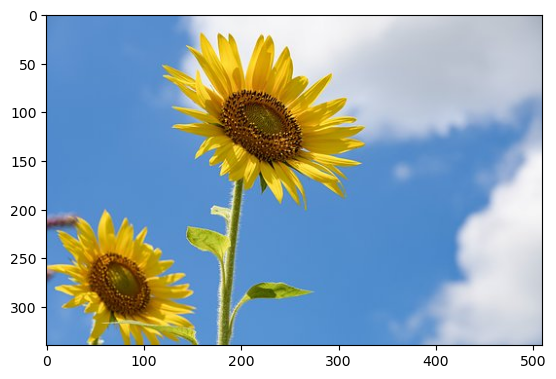

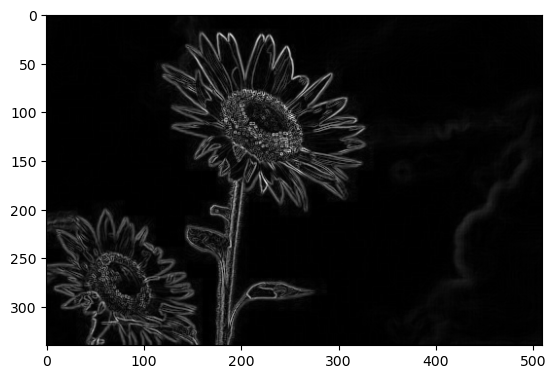

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:15<00:00, 15.52it/s]


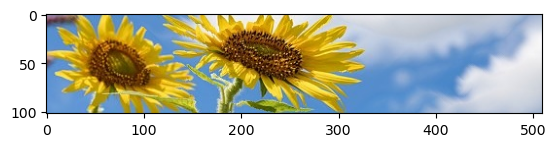

In [7]:
from ctypes.wintypes import RGB
import sys
import time
import cv2 as cv
import numba
from tqdm import trange
import numpy as np
from imageio.v2 import imread, imwrite
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import warnings

warnings.filterwarnings("ignore", category=numba.NumbaWarning)
#from scipy.signal import convolve

#@numba.jit(nopython=True)
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

#tìm một đường đi từ trên cùng của hình ảnh đến cuối hình ảnh với ít năng lượng nhất; các điểm phải được kết nối với nhau qua 1 cạch hoặc 1 góc
@numba.jit
def minimum_seam(img):
    r, c, _ = img.shape  # (533,800.3)
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=int)  #Toàn bộ số 0 shape giống M

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            # Handle the right edge of the image, to ensure we don't go out of bounds
            elif j == c - 1:
                idx = np.argmin(M[i - 1, j - 1:j + 1])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]
            M[i, j] += min_energy


    return M, backtrack
# Loại bỏ các pixel trên đường seam vả đặt lại kích thước của ảnh
@numba.jit
def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    show_seam(img, get_seam(backtrack))

    mask = np.ones((r, c), dtype=bool)

    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img

# thêm các pixel vào bên phải đừng seam
@numba.jit
def insert_column(img, M, backtrack):
    r, c, _ = img.shape
    
    # Tính seam tối thiểu trên ảnh mới
    new_M, new_backtrack = minimum_seam(img)
    
    # Chọn seam tối thiểu để chèn pixel mới vào ảnh
    j = np.argmin(new_M[-1])
    
    show_seam(img, get_seam(new_backtrack))
    
    # Tạo ảnh mới với kích thước lớn hơn ảnh cũ 1 cột
    new_img = np.zeros((r, c + 1, 3), dtype=np.uint8)
    
    for i in reversed(range(r)):
        # Chèn thêm pixel mới tại vị trí j
        new_img[i, :j+1, :] = img[i, :j+1, :]
        new_img[i, j+2:, :] = img[i, j+1:, :]

        # Tính giá trị pixel mới
        if j == 0:
            new_pixel = img[i, j, :]
        elif j == c-1:
            new_pixel = img[i, j, :]
        else:
            idx = np.argmin(new_M[i-1, j-1:j+2])
            new_pixel = np.average(img[i, j-1:j+2, :], axis=0)

        new_img[i, j+1, :] = new_pixel

        # Cập nhật backtrack
        new_j = j + 1
        if j == 0:
            idx = np.argmin(new_M[i-1, j:j+2])
            new_j = idx + j
        elif j == c-1:
            idx = np.argmin(new_M[i-1, j-1:j+1])
            new_j = idx + j - 1
        else:
            idx = np.argmin(new_M[i-1, j-1:j+2])
            new_j = idx + j - 1
        backtrack[i, j] = new_j

        # Cập nhật M
        min_energy = M[i-1, new_j]
        M[i, j] += min_energy

        j = new_j
    
    return new_img, new_M, new_backtrack


def show_seam(img, seam):
    img_seam = img.copy()
    for i in range(img.shape[0]):
        img_seam[i, seam[i]] = [0, 0, 255]

    cv.imshow("Seam", img_seam)  
    cv.waitKey(1)
    
def get_seam(backtrack):
    r, c = backtrack.shape
    seam = []
    j = np.argmin(backtrack[-1])  # Tìm cột của điểm ảnh có giá trị nhỏ nhất tại hàng cuối cùng
    seam.append(j)

    for i in range(r-2, -1, -1):
        j = backtrack[i+1, j]  # Lấy vị trí cột của điểm ảnh trên dòng trên đường seam
        seam.append(j)

    seam.reverse()
    return np.array(seam)

def resize_c(img, scale_r):
    r, c, _ = img.shape
    new_r = int(scale_r * r)

    # Tính seam tối thiểu trên ảnh ban đầu
    M, backtrack = minimum_seam(img)

    for i in trange(new_r - r):
        # Thêm một cột mới vào ảnh
        img, M, backtrack = insert_column(img, M, backtrack)
    
    #cv.imshow("Seam",img)
    return img

def resize_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = resize_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    cv.imshow("Seam",img)
    return img

# Cắt ảnh theo chiều rộng
def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c):
        img = carve_column(img)
    cv.imshow("Seam",img)
    return img
# Cắt ảnh theo chiều cao
def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    cv.imshow("Seam",img)
    return img


# Hàm chạy chính
def main():

    sys.argv = ["1.py" , "r" , 0.3, "flower.jpg" , "flower1.jpg"]
    print(sys.argv[1])
    if len(sys.argv) != 5:
        print('usage: carver.py <r/c> <scale> <image_in> <image_out>', file=sys.stderr)
        sys.exit(1)

    which_axis = sys.argv[1]
    scale = float(sys.argv[2])
    in_filename = sys.argv[3]
    out_filename = sys.argv[4]

    img = cv.imread(in_filename)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()


    plt.imshow(calc_energy(img), cmap='gray')
    plt.show()
    
    
    #imwrite("energy_map.jpg", calc_energy(img))
    if which_axis == 'r':
        out = crop_r(img, scale)
    elif which_axis == 'c':
        out = crop_c(img, scale)
    elif which_axis == 'rr':
        out = resize_r(img, scale)
    elif which_axis == 'rc':
        out = resize_c(img, scale)
    else:
        print('usage: carver.py <r/c> <scale> <image_in> <image_out>', file=sys.stderr)
        sys.exit(1)
        
    cv.imwrite(out_filename, out)
    img1 = cv.imread(out_filename) 
    plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
    plt.show()
    cv.waitKey(0)
    cv.destroyAllWindows()
  

if __name__ == '__main__':
    main()





In [ ]:
def minimum_seam(img):
    r, c, _ = img.shape  # Lấy kích thước của ảnh, r là chiều cao, c là chiều rộng và _ là số kênh màu (ở đây không cần thiết)
    energy_map = calc_energy(img)  # Tính toán bản đồ năng lượng của ảnh đầu vào

    M = energy_map.copy()  # Khởi tạo ma trận M với giá trị bằng ma trận bản đồ năng lượng
    backtrack = np.zeros_like(M, dtype=int)  # Khởi tạo ma trận backtrack với giá trị bằng 0 và cùng kích thước với M

    for i in range(1, r):  # Duyệt qua từng hàng (từ hàng 1 đến hàng cuối cùng)
        for j in range(0, c):  # Duyệt qua từng cột (từ cột đầu tiên đến cột cuối cùng)
            # Xử lý cho cạnh trái của ảnh để đảm bảo không truy cập vào phần tử -1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])  # Tìm vị trí của phần tử nhỏ nhất trong M ở hàng trên đó và ở cột hiện tại và cột kế tiếp
                backtrack[i, j] = idx + j  # Lưu lại vị trí của phần tử nhỏ nhất tại hàng trên đó và cột kế tiếp
                min_energy = M[i - 1, idx + j]  # Lưu lại giá trị năng lượng nhỏ nhất tại hàng trên đó và cột kế tiếp
            # Xử lý cho cạnh phải của ảnh để đảm bảo không truy cập vào phần tử vượt quá kích thước của ảnh
            elif j == c - 1:
                idx = np.argmin(M[i - 1, j - 1:j + 1])  # Tìm vị trí của phần tử nhỏ nhất trong M ở hàng trên đó và ở cột trước đó và cột hiện tại
                backtrack[i, j] = idx + j - 1  # Lưu lại vị trí của phần tử nhỏ nhất tại hàng trên đó và cột trước đó
                min_energy = M[i - 1, idx + j - 1]  # Lưu lại giá trị năng lượng nhỏ nhất tại hàng trên đó và cột trước đó
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])  # Tìm vị trí của phần tử nhỏ nhất trong M ở hàng trên đó và